# Events Table Stratified

__Description__: 
A distribution of runoffs is derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period or exceedance probability)

    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import hydromet_JSON_to_DSS_v2
import mean_frequency_curve
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [2]:
## Excess rainfall parameters:
CN  = 81  # Curve number, must be an integer
mu  = 0.2  # Intial abstraction ratio parameter
PMP = 39.9  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
lower_limit = 1 # Lower limit of NOAA Atlas 14 precipitation values
Aerial_Reduction = 1.0  # Aerial reduction factor
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file


## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'Amite'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN = 'D01'  # Domain/boundary condition name
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
CN_Distribution = 'NEH630_Table_10_1.json'
nrcs_precip_table = '{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NRCS Data
atlas14_precip_table = '{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # Atlas 14 Temporal Data

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
1,4.278450,3.550713,5.134769
2,5.000066,4.145173,6.005280


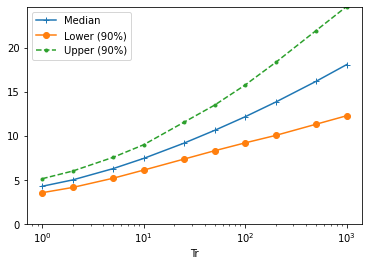

In [4]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [5]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,4.787682,3.966777,5.810775
sigma,1.005912,0.928914,1.100000
xi,-0.179167,-0.076009,-0.257440


#### Plot fitted GEV distribution and NOAA data:

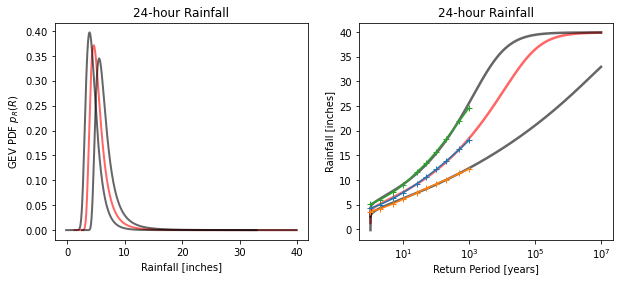

In [6]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP, 'Rainfall')

### Retrieve Max Potential Retention Variability and Distribution Parameters:

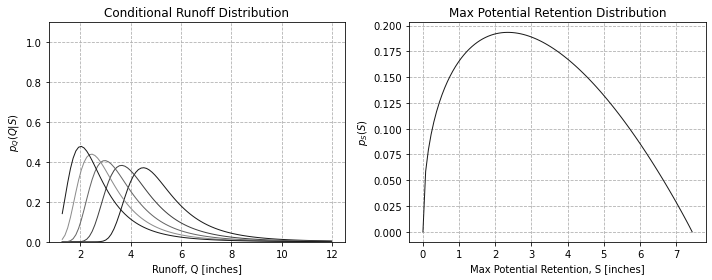

In [7]:
## NRCS value of wet and dry soil moiture conditions:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

## Table of wet, dry, and average (or median) soil moisture conditions:
df_CN = prep_cn_table(CN, arc_data)  

## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)
fitted_cn['mu'] = mu

## Distribution parameter values:
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

## Define probability for each partition of the max potential retention distribution:
Delta_P = 1.0/n_partition

## Find the average value over each partition, which is the basis for the runoff distribution:
partition_avg = partition_S_avgs(n_partition, Delta_P, alpha, beta, S_limit)

GEV_parameters_M = df_GEV_parameters_M.values.transpose()[0]
plot_runoff_maxRetention_distributions(GEV_parameters_M, PMP, fitted_cn)

#### Calculate the error in the numerical CDF evaluated at PMP:

In [8]:
## Error between the integral approach (based on summation integration) and the actual value:
error_PQ = 1-CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_M, PMP, partition_avg, Delta_P, 0)

print('\nProbability of zero runoff = {}\nError in calculation of Probabilibity of zero runoff = {}\n'
      'Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = {}'
      ''.format(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_M, PMP, error_PQ)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_M, PMP, error_PQ)[1], error_PQ))


Probability of zero runoff = 1.3620245307037112e-66
Error in calculation of Probabilibity of zero runoff = 2.645859477598788e-66
Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = -5.489744370201777e-06


### Determine Runoff Values and Weights:
#### Fit GEV to runoff data (find GEV parameters):

In [9]:
df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_M, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
GEV_parameters_R = df_GEV_parameters_R.values.transpose()[0]
df_GEV_parameters_R

,GEV Runoff
mu,2.666056
sigma,0.950172
xi,-0.182098


#### Plot fitted rainfall and runoff GEV distributions:

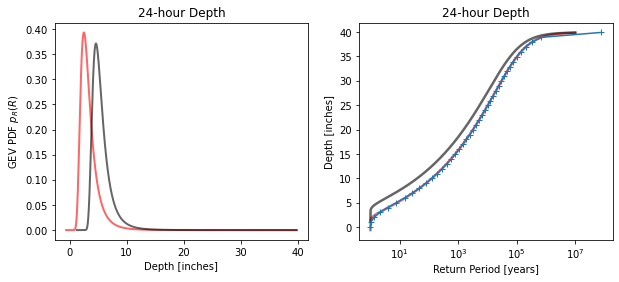

In [10]:
plot_GEV_precip_curves(df_runoff, pd.concat([df_GEV_parameters_R, df_GEV_parameters_M], axis=1), PMP, 'Depth')

# Here we need to provide Exceedance probabilities that correspond to the flood extents we are examining. For each exceedence probability (corresponding to a flood extent) this calc provides the corresponding rainfall index, which is the value for the exceedance probaibility normalized by the 100-year event.

In [12]:
Exceedance_Probability = np.array([.00001,.0001,.5]) #These values are used to identify flood extents
Non_Exceedance_Probability = 1 - Exceedance_Probability

#The rainfall value for a given exeedance probaiblity normalized by the rainfall value for the 100 year event with exceedance probailbity 1-0.01
PPF_GEV(Non_Exceedance_Probability, df_GEV_parameters_R.values, PMP)/PPF_GEV(1-.01, df_GEV_parameters_R.values, PMP)

array([3.66877057, 2.61825894, 0.31839329])